# Sweet Lift Taxi Company 🚗

 🚗  🚗  🚗 a time series project, by Deborah Thomas  🚗  🚗  🚗  🚗  🚗  🚗

https://github.com/Script-Whiz/Sprint13_SweetTaxi_timeSeries/blob/master/notebooks/Sprint13_SweetTaxi_timeSeries_ver4.ipynb

# Introduction

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.



# Goals

- Download the data and resample it by one hour.
- Analyze the data.
- Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
- Test the data using the test sample and provide a conclusion.

# Import Libraries

In [10]:
import pandas as pd
import numpy as np

import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
import pmdarima as pm

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score

# Load in the data:

<b>Read in the data with date as index:</b>

In [13]:
try:
    # Attempt to read from the server path
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
except FileNotFoundError:
    # Fallback to the local path
    df = pd.read_csv('../datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
    print("CSV file loaded successfully from the local path.")
else:
    # This block runs if no exception is raised in the try block
    print("CSV file loaded successfully from the server path.")
finally:
    # This block is always executed, no matter if an exception is thrown or not
    print("It's a great day.")

CSV file loaded successfully from the local path.
It's a great day.


<b>Check to make sure that the index is increasing; example 1,2,3,4, and not zigzaggin; example 3,12,1,47. We want this to output True.</b>

In [15]:
# Check if the index is monotonic increasing
if not df.index.is_monotonic_increasing:
    df.sort_index(inplace=True)  # Sort the index if needed

<b>Check original shape of data</b>

In [17]:
df.shape

(26496, 1)

In [18]:
print(df.head(12))

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
2018-03-01 00:50:00          21
2018-03-01 01:00:00           7
2018-03-01 01:10:00           5
2018-03-01 01:20:00          17
2018-03-01 01:30:00          12
2018-03-01 01:40:00          19
2018-03-01 01:50:00          25


Original data is every 10 minutes.

In [20]:
print('Average number of orders per 10-minutes:', df['num_orders'].median())

Average number of orders per 10-minutes: 13.0


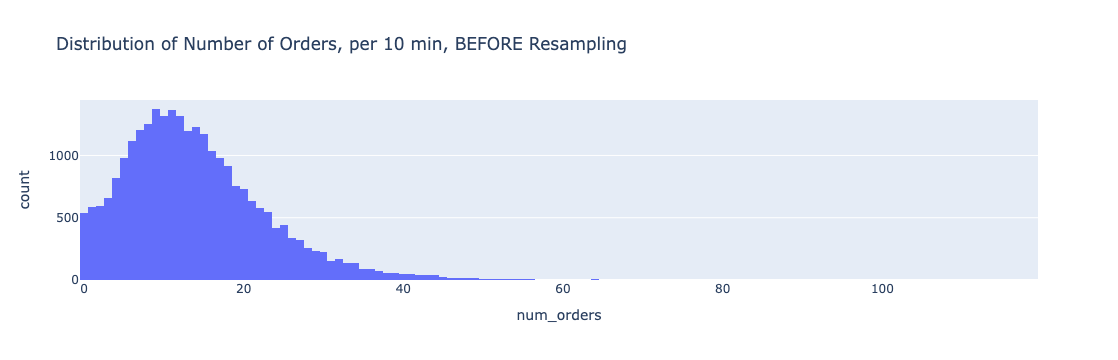

In [21]:
fig = px.histogram(df, x='num_orders', title='Distribution of Number of Orders, per 10 min, BEFORE Resampling')
fig.show()

In [22]:
print(df.num_orders.mean())

14.070463466183575


The data is left skewed. Before resampling, the mean is 14. 

<b>Before resampling, check the math of what the shape should be AFTER it is resampled.</b>

In [25]:
df.shape[0] / 6

4416.0

In [26]:
# Calculate the sum of the first 6 values in the `num_orders` column:
first_six_sum = df['num_orders'].iloc[:6].sum()
print('\n')
print("Sum of the first 6 values, which will become the first value, in num_orders, AFTER resampling by hour:", first_six_sum)
print('\n')



Sum of the first 6 values, which will become the first value, in num_orders, AFTER resampling by hour: 124




<b>Resample the data to be every hour:</b>

In [28]:
df = df.resample('1h').sum()

<b>Check shape of data after resampling:</b>

In [30]:
df.shape

(4416, 1)

In [31]:
#old code:
26496 / 6

4416.0

The resampling changed the data from every 10 minutes(that would mean that there used to be 6 per hour), to every hour. So the shape is now 1/6th the size that it used to be. My earlier estimation, of what the shape would be, after resampling, was correct. (1/6th the original size.)

In [33]:
print(df.head(12))

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6
2018-03-01 06:00:00          12
2018-03-01 07:00:00          15
2018-03-01 08:00:00          34
2018-03-01 09:00:00          69
2018-03-01 10:00:00          64
2018-03-01 11:00:00          96


In [34]:
#old code:
#9 + 14 + 28 + 20+ 32 + 21

The num_orders are much bigger now, after resampling. For each hour, it adds up the six entries that were previously recorded every 10 minutes. So, for the first hour ("00:00" to "01:00"), the total number of orders becomes 124, calculated by summing up 9, 14, 28, 20, 32, and 21.

# Preparation of data:

<b>Check for NaN values:</b>

In [38]:
nan_num_orders = df.num_orders.isna().sum()
print("Number of NaN values in num_orders:", nan_num_orders)

Number of NaN values in num_orders: 0


In [39]:
nan_in_index = pd.isna(df.index).any()
print(nan_in_index)

False


<b>There are no NaN values in the index of the DataFrame.</b>

<b>Check for missing values:</b>

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


There are no missing values.

<b>Check value counts:</b>

In [45]:
df.num_orders.value_counts()

num_orders
73     65
57     58
66     58
78     54
84     52
       ..
200     1
272     1
462     1
239     1
207     1
Name: count, Length: 251, dtype: int64

<b>Check min / max:</b>

In [47]:
df.num_orders.max()

462

In [48]:
df.num_orders.min()

0

Data is clean.

# Analysis:

In [51]:
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

<b>Check distribution:</b>

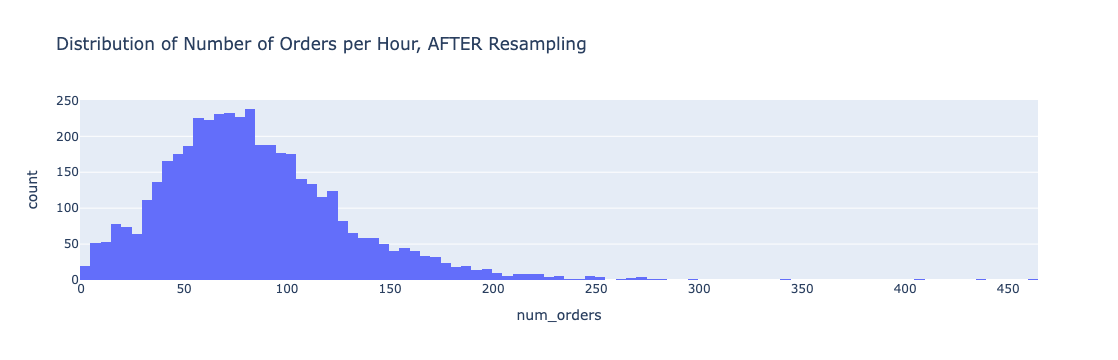

In [53]:
fig = px.histogram(df, x='num_orders', title='Distribution of Number of Orders per Hour, AFTER Resampling')
fig.show()

In [54]:
df.mean()

num_orders    84.422781
dtype: float64

In [55]:
df.mean() / 6

num_orders    14.070463
dtype: float64

The data is left skewed, with most num_orders being between 55-84 per hour. After resampling, the mean is 84.42 (per hour). This is 6 times higher than the mean of num_orders, before resampling(14).

- <b>Look at orders by various hours:</b>

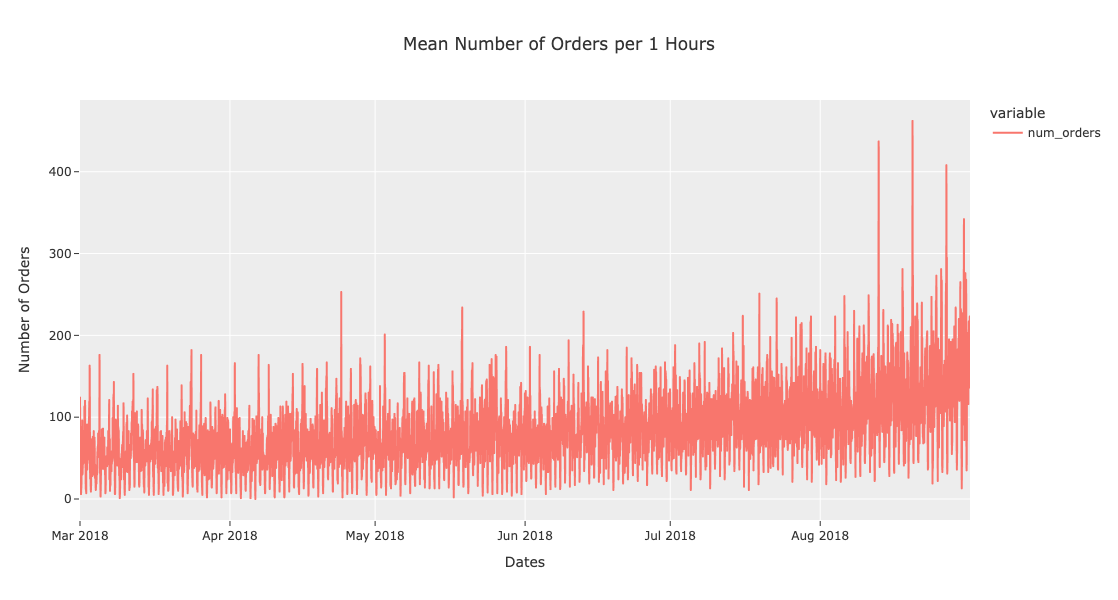

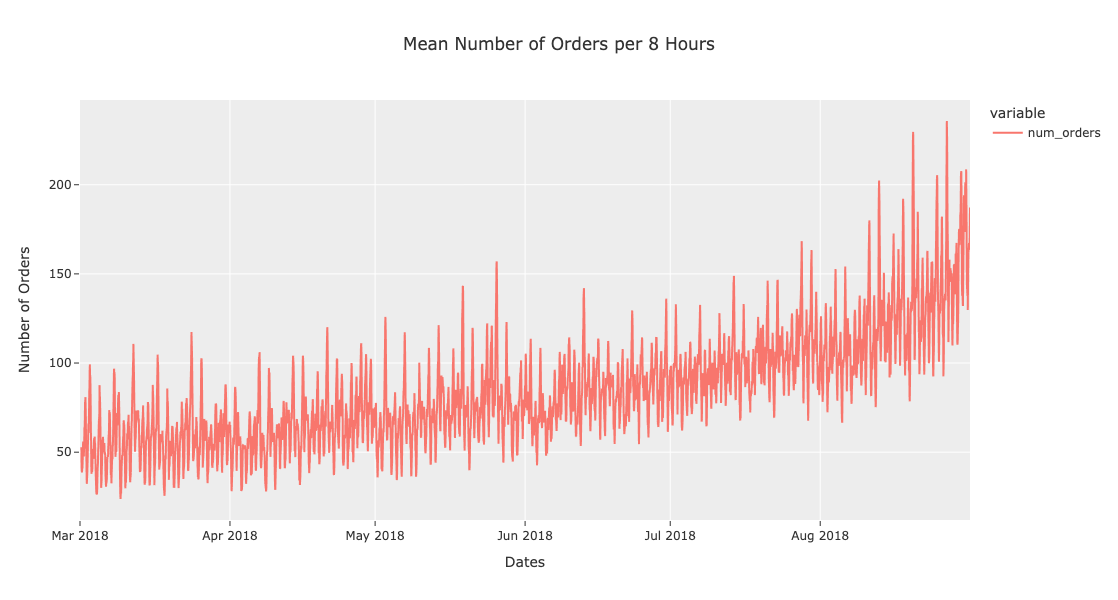

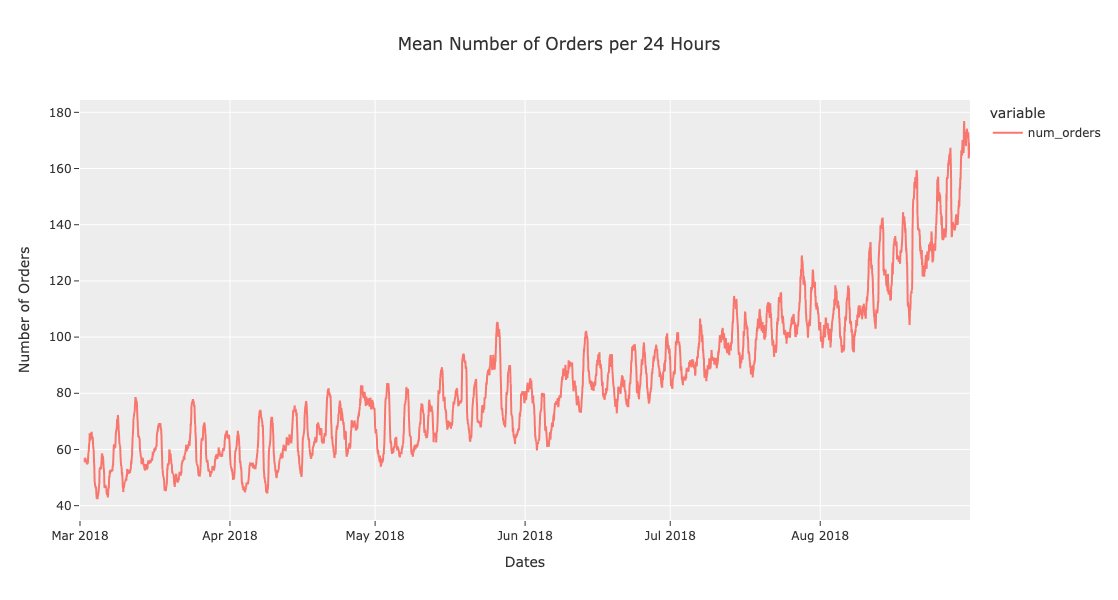

In [58]:
# Average daily orders, per 1-hour, per 8-hours, per 24-hours.
numbers = [1, 8, 24] 
for i in numbers:
    px.line(df.num_orders.rolling(i).mean(), title=f'Mean Number of Orders per {i} Hours', template='ggplot2', labels={'value': 'Number of Orders', 'datetime':'Dates'}, height=600).show()


There is a clear positive trend. Daily sales are increasing as the months go on.

- <b>Find correlations:</b>

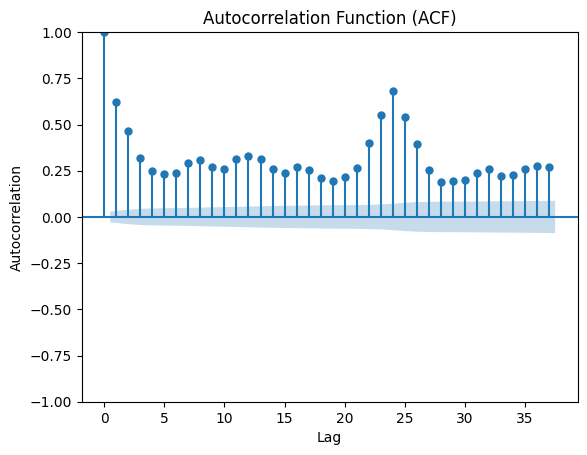

In [61]:
# Plot the Autocorrelation Function (ACF)
plot_acf(df['num_orders'])
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

It spikes at 0 ad 24. This suggests daily seasonality. 

- <b>Look at Rolling Mean with Original Data (before removing seasonality):</b>

In [64]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()

    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')

    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

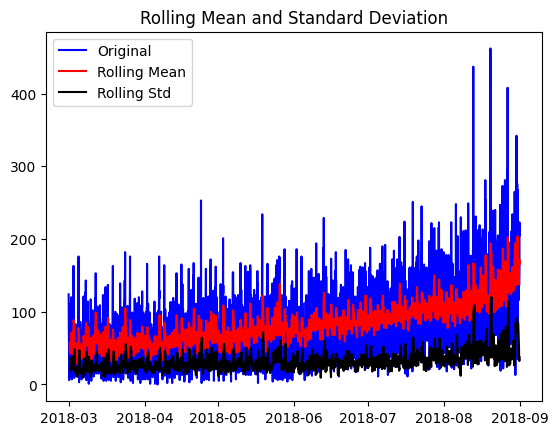

In [65]:
test_stationarity(df['num_orders'])

If the rolling mean was a flat line, then the data would be considered stationary. It is not flat, so this means that the data is not stationary.

- Blue Line (Original data): This  represents the actual data points in the time series. The 'Original' series shows the actual values, which have noise.

- Red Line (Rolling Mean): A rolling mean (or moving average) smoothens out the data by averaging consecutive points. It reveals the underlying trend more clearly by reducing noise. There is a clear positive trend in the data.

- Black Line (Rolling Standard Deviation): The rolling standard deviation indicates how much the values in the time series deviate from the rolling mean over the same period. A small rolling standard deviation suggests that the data points are closely grouped around the mean. The variability is low, and the data points are relatively consistent around the mean.

Upward Trend: The upward trend in the rolling mean indicates that there is a consistent increase in the 'num_orders' over time. This could be due to seasonal effects, general growth in demand, or other factors influencing the dataset.



- <b>Eliminating Trend and Seasonality</b>

In [100]:
pd.set_option('future.no_silent_downcasting', True)

# Explicitly convert Series to float after clip
positive_num_orders = df['num_orders'].clip(lower=1e-9).astype(np.float64)
ts_log = np.log1p(positive_num_orders)

In [102]:
ts_log_diff = ts_log - ts_log.shift()

If we have trend and seasonality, which we do, we cannot do forecasting on it. We must make the data stationary first. 

- <b>Differencing ... make data stationary:</b>

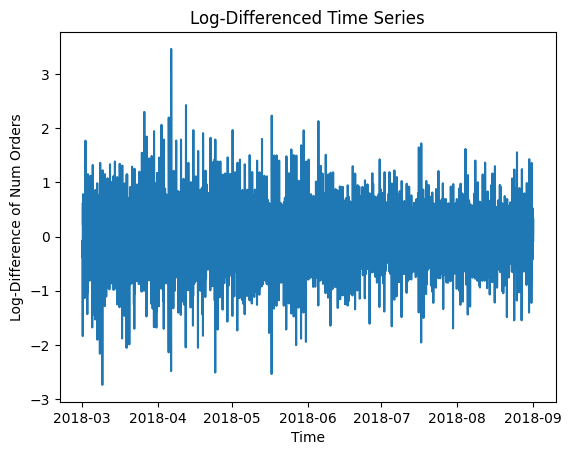

In [106]:
plt.plot(ts_log_diff.dropna())
plt.title("Log-Differenced Time Series")
plt.xlabel("Time")
plt.ylabel("Log-Difference of Num Orders")
plt.show()

Taking the original data, and minusing the shift, is called "differencing". The point is to make the data stationary. The line is now flat.

- <b>Decompositioning. Find seasonality with Log data:</b>

In [110]:
# Decompose the Time Series
decompose_result = seasonal_decompose(df['num_orders'], model='additive', period=24) # Assuming daily seasonality

In [112]:
# Extract components
df['trend'] = decompose_result.trend
df['seasonal'] = decompose_result.seasonal
df['residual'] = decompose_result.resid

In [114]:
# Drop NaN values caused by decomposition
df.dropna(inplace=True)

In [116]:
display(df.head(4))

num_orders      trend   seasonal   residual
datetime                                                        
2018-03-01 12:00:00          30  56.125000 -16.721606  -9.403394
2018-03-01 13:00:00          32  56.145833 -13.352412 -10.793422
2018-03-01 14:00:00          48  56.958333  -9.191665   0.233331
2018-03-01 15:00:00          66  57.000000   3.731832   5.268168

There are now 3 added columns.

- Plot the result

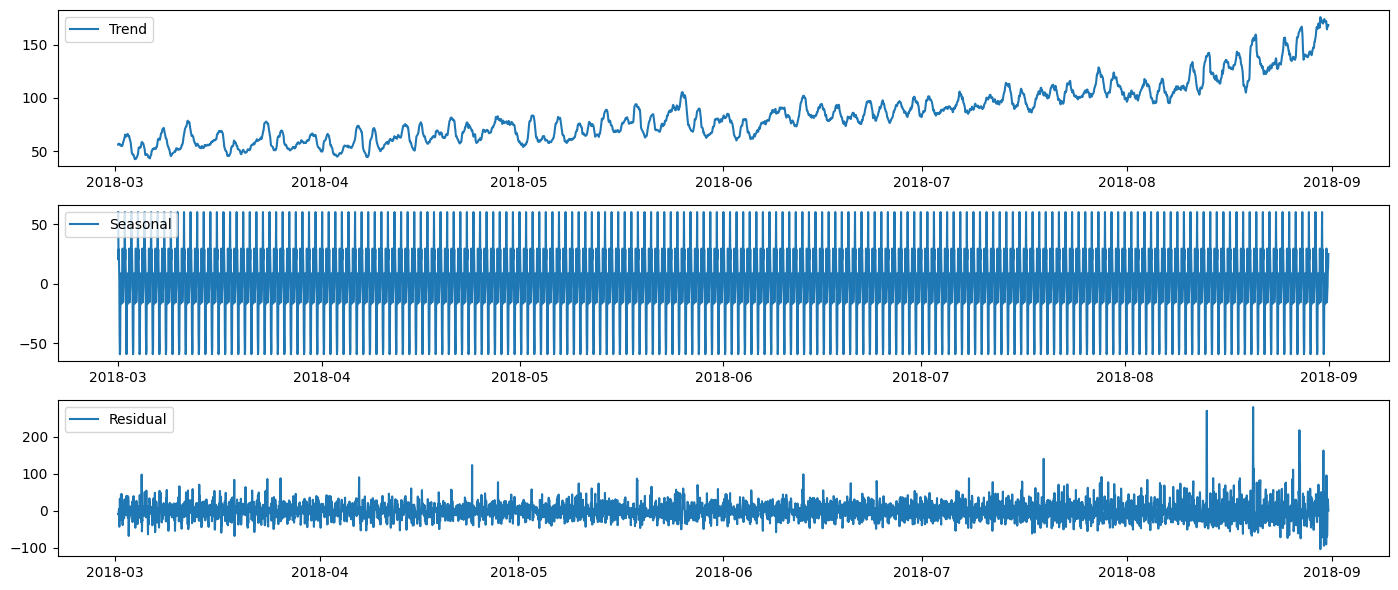

In [120]:
def plot_decomposition(decompose_result):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(311)
    plt.plot(decompose_result.trend, label='Trend')
    plt.legend(loc='upper left')
    
    plt.subplot(312)
    plt.plot(decompose_result.seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    
    plt.subplot(313)
    plt.plot(decompose_result.resid, label='Residual')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()
plot_decomposition(decompose_result)

There is a positive trend on the Trend plot, and a repeated pattern on the Seasonal plot, and variety on the Residual plot. So, there definitely is still seasonality and trend.

- <b>Look at Rolling Mean with Residual Data:</b>

In [124]:
ts_log_decompose = df['residual']

In [126]:
ts_log_decompose.dropna(inplace=True)

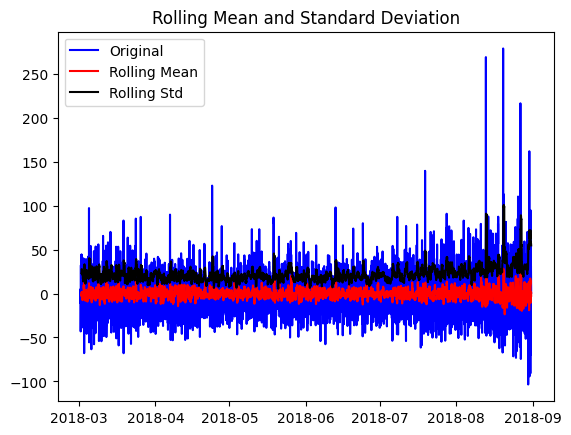

In [128]:
test_stationarity(ts_log_decompose)

There is less seasonality. So, it is okay to move on with forecasting.

# Training: 

In [132]:
display(df)

num_orders       trend   seasonal   residual
datetime                                                         
2018-03-01 12:00:00          30   56.125000 -16.721606  -9.403394
2018-03-01 13:00:00          32   56.145833 -13.352412 -10.793422
2018-03-01 14:00:00          48   56.958333  -9.191665   0.233331
2018-03-01 15:00:00          66   57.000000   3.731832   5.268168
2018-03-01 16:00:00          43   56.479167  29.604100 -43.083267
...                         ...         ...        ...        ...
2018-08-31 07:00:00          46  166.208333 -55.104461 -65.103873
2018-08-31 08:00:00         182  167.791667 -11.212840  25.421173
2018-08-31 09:00:00         203  167.229167   4.443581  31.327252
2018-08-31 10:00:00         191  167.770833   8.759269  14.469898
2018-08-31 11:00:00         167  168.270833  -2.133377   0.862544

[4392 rows x 4 columns]

- <b>Make Features using num_orders:</b>

In [139]:
# Add lag and rolling mean columns from original (seasonal) data
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['rolling_mean'] = df['num_orders'].rolling(3).mean().shift(1)

In [141]:
display(df.head(4))

num_orders      trend   seasonal   residual  lag_1  \
datetime                                                                  
2018-03-01 12:00:00          30  56.125000 -16.721606  -9.403394    NaN   
2018-03-01 13:00:00          32  56.145833 -13.352412 -10.793422   30.0   
2018-03-01 14:00:00          48  56.958333  -9.191665   0.233331   32.0   
2018-03-01 15:00:00          66  57.000000   3.731832   5.268168   48.0   

                     lag_2  rolling_mean  
datetime                                  
2018-03-01 12:00:00    NaN           NaN  
2018-03-01 13:00:00    NaN           NaN  
2018-03-01 14:00:00   30.0           NaN  
2018-03-01 15:00:00   32.0     36.666667

This added 3 more columns to the dataframe.

In [144]:
# Add time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['week_number'] = df.index.isocalendar().week

In [146]:
display(df.head(4))

num_orders      trend   seasonal   residual  lag_1  \
datetime                                                                  
2018-03-01 12:00:00          30  56.125000 -16.721606  -9.403394    NaN   
2018-03-01 13:00:00          32  56.145833 -13.352412 -10.793422   30.0   
2018-03-01 14:00:00          48  56.958333  -9.191665   0.233331   32.0   
2018-03-01 15:00:00          66  57.000000   3.731832   5.268168   48.0   

                     lag_2  rolling_mean  hour  day_of_week  month  \
datetime                                                             
2018-03-01 12:00:00    NaN           NaN    12            3      3   
2018-03-01 13:00:00    NaN           NaN    13            3      3   
2018-03-01 14:00:00   30.0           NaN    14            3      3   
2018-03-01 15:00:00   32.0     36.666667    15            3      3   

                     week_number  
datetime                          
2018-03-01 12:00:00            9  
2018-03-01 13:00:00            9  
2018-03-01 14:00:00            9  
2018-03-01 15:00:00            9

This added 4 more columns to the dataframe.

num_orders is the target.

In [150]:
# Drop rows with missing values
df.dropna(inplace=True)

<b>Split in to features and target:</b>

In [153]:
# Define features and target. 'residual' has been added to this list.
features_col = ['residual', 'lag_1', 'lag_2', 'rolling_mean', 'hour', 'day_of_week', 'month', 'week_number']
features = df[features_col]

#old code ... target = df['residual']
target = df['num_orders']

<b>Split the data. Test size will be 10\% of the data.</b>

In [156]:
# Split Data Chronologically
split_index = int(len(df) * 0.9)
features_train, features_test = features[:split_index], features[split_index:]
target_train, target_test = target[:split_index], target[split_index:]

In [158]:
features_train

residual  lag_1  lag_2  rolling_mean  hour  \
datetime                                                            
2018-03-01 15:00:00    5.268168   48.0   32.0     36.666667    15   
2018-03-01 16:00:00  -43.083267   66.0   48.0     48.666667    16   
2018-03-01 17:00:00  -20.024182   43.0   66.0     52.333333    17   
2018-03-01 18:00:00   32.340458   44.0   43.0     51.000000    18   
2018-03-01 19:00:00   -3.875730   73.0   44.0     53.333333    19   
...                         ...    ...    ...           ...   ...   
2018-08-13 00:00:00  -39.477279  185.0  118.0    146.000000     0   
2018-08-13 01:00:00  114.260426  160.0  185.0    154.333333     1   
2018-08-13 02:00:00  269.517257  273.0  160.0    206.000000     2   
2018-08-13 03:00:00   11.114593  437.0  273.0    290.000000     3   
2018-08-13 04:00:00    0.854688  168.0  437.0    292.666667     4   

                     day_of_week  month  week_number  
datetime                                              
2018-03-01 15:00:00            3      3            9  
2018-03-01 16:00:00            3      3            9  
2018-03-01 17:00:00            3      3            9  
2018-03-01 18:00:00            3      3            9  
2018-03-01 19:00:00            3      3            9  
...                          ...    ...          ...  
2018-08-13 00:00:00            0      8           33  
2018-08-13 01:00:00            0      8           33  
2018-08-13 02:00:00            0      8           33  
2018-08-13 03:00:00            0      8           33  
2018-08-13 04:00:00            0      8           33  

[3950 rows x 8 columns]

In [160]:
features_test

residual  lag_1  lag_2  rolling_mean  hour  day_of_week  \
datetime                                                                        
2018-08-13 05:00:00 -15.374478  143.0  168.0    249.333333     5            0   
2018-08-13 06:00:00 -16.067329   83.0  143.0    131.333333     6            0   
2018-08-13 07:00:00 -47.874706   66.0   83.0     97.333333     7            0   
2018-08-13 08:00:00 -39.620494   39.0   66.0     62.666667     8            0   
2018-08-13 09:00:00  -9.464414   91.0   39.0     65.333333     9            0   
...                        ...    ...    ...           ...   ...          ...   
2018-08-31 07:00:00 -65.103873   35.0   78.0    127.000000     7            4   
2018-08-31 08:00:00  25.421173   46.0   35.0     53.000000     8            4   
2018-08-31 09:00:00  31.327252  182.0   46.0     87.666667     9            4   
2018-08-31 10:00:00  14.469898  203.0  182.0    143.666667    10            4   
2018-08-31 11:00:00   0.862544  191.0  203.0    192.000000    11            4   

                     month  week_number  
datetime                                 
2018-08-13 05:00:00      8           33  
2018-08-13 06:00:00      8           33  
2018-08-13 07:00:00      8           33  
2018-08-13 08:00:00      8           33  
2018-08-13 09:00:00      8           33  
...                    ...          ...  
2018-08-31 07:00:00      8           35  
2018-08-31 08:00:00      8           35  
2018-08-31 09:00:00      8           35  
2018-08-31 10:00:00      8           35  
2018-08-31 11:00:00      8           35  

[439 rows x 8 columns]

In [162]:
target_train

datetime
2018-03-01 15:00:00     66
2018-03-01 16:00:00     43
2018-03-01 17:00:00     44
2018-03-01 18:00:00     73
2018-03-01 19:00:00     45
                      ... 
2018-08-13 00:00:00    160
2018-08-13 01:00:00    273
2018-08-13 02:00:00    437
2018-08-13 03:00:00    168
2018-08-13 04:00:00    143
Freq: h, Name: num_orders, Length: 3950, dtype: int64

In [164]:
target_test

datetime
2018-08-13 05:00:00     83
2018-08-13 06:00:00     66
2018-08-13 07:00:00     39
2018-08-13 08:00:00     91
2018-08-13 09:00:00    137
                      ... 
2018-08-31 07:00:00     46
2018-08-31 08:00:00    182
2018-08-31 09:00:00    203
2018-08-31 10:00:00    191
2018-08-31 11:00:00    167
Freq: h, Name: num_orders, Length: 439, dtype: int64

There is just one column; num_orders. datetime is the index.

<b>Create models:</b>

- Linear Regression

In [169]:
lr = LinearRegression()

In [171]:
lr.fit(features_train, target_train)

LinearRegression()

- Decision Tree:

In [174]:
def find_best_decision_tree(features_train, target_train, features_test, target_test):
    best_model = None
    best_result = 100
    best_depth = 6
    
    for depth in range(1, 6):  # Choose hyperparameter range
        dtr = DecisionTreeRegressor(random_state=19, max_depth=depth)
        
        dtr.fit(features_train, target_train)  # Train model
        predictions_valid_dtr = dtr.predict(features_test)  # Validate model
        result = mean_squared_error(target_test, predictions_valid_dtr) ** 0.5
        
        if result < best_result:
            best_model = dtr
            best_result = result
            best_depth = depth
    
    return best_model, best_result, best_depth

- <b>Random Forest</b>

In [177]:
def find_best_random_forest(features_train, target_train, features_test, target_test):
    best_model = None
    best_result = float('inf')
    best_params = None
    for est in range(1100, 1301, 100):
        for depth in range(70, 100, 20):
            for min_samples_split in range(2, 5, 10):
                for max_features in [None, 'sqrt', 'log2']:
                    print(f"Training with: n_estimators={est}, max_depth={depth}, min_samples_split={min_samples_split}, max_features={max_features}")
                    rf = RandomForestRegressor(
                        random_state=19, 
                        n_estimators=est, 
                        max_depth=depth,
                        min_samples_split=min_samples_split,
                        max_features=max_features
                    )
                    rf.fit(features_train, target_train)
                    predictions_test = rf.predict(features_test)
                    
                    # Calculate Mean Squared Error
                    mse = mean_squared_error(target_test, predictions_test)
                    # Calculate Root Mean Squared Error
                    rmse = np.sqrt(mse)
                    
                    print(f"RMSE: {rmse}")
                    if rmse < best_result:
                        best_model = rf
                        best_result = rmse
                        best_params = (est, depth, min_samples_split, max_features)
    if best_params:
        print(f"Best RMSE: {best_result} with params n_estimators={best_params[0]}, "
              f"max_depth={best_params[1]}, min_samples_split={best_params[2]}, "
              f"max_features={best_params[3]}")
    else:
        print("No valid model was found.")
    return best_model, best_result, best_params


- <b>Gradient Boost. Find best params.</b>

In [180]:
def find_best_gradient_boost(features_train, target_train, features_test, target_test):
    best_model = None
    best_result = float('inf')
    best_params = None
    try:
        for n_estimators in range(100, 201, 50):
            for max_depth in range(4, 7, 1):
                for learning_rate in [0.1, 0.05, 0.01, 0.005]:
                    gbr = GradientBoostingRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        learning_rate=learning_rate,
                        random_state=19
                    )
                    gbr.fit(features_train, target_train)
                    predictions_valid_gbr = gbr.predict(features_test)
                    result = mean_squared_error(target_test, predictions_valid_gbr) ** 0.5
                    print(f"RMSE: {result} with params n_estimators={n_estimators}, "
                          f"max_depth={max_depth}, learning_rate={learning_rate}")
                    if result < best_result:
                        best_model = gbr
                        best_result = result
                        best_params = (n_estimators, max_depth, learning_rate)
                        
        if best_model:
            print('\n')
            print(f"Best RMSE: {best_result} with params n_estimators={best_params[0]}, "
                  f"max_depth={best_params[1]}, learning_rate={best_params[2]}")
            
    except Exception as e:
        print(f"An error occurred: {e}")
        
    return best_model, best_result, best_params

- <b>Run Gradient Boost Prediction with best parameters:</b>

In [183]:
def get_fixed_gradient_boost(features_train, target_train, features_test, target_test):
    # Best hyperparameters
    n_estimators = 200
    max_depth = 4
    learning_rate = 0.1
   
    # Initialize the model with fixed parameters
    gbr = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=19,
        validation_fraction=0.1,  # Fraction of training data for early stopping
        n_iter_no_change=5,       # Stop if no improvement in this many iterations
        tol=0.01                  # Tolerance of the error change
    )
    # Fit the model
    gbr.fit(features_train, target_train)
    # Make predictions
    predictions_valid_gbr = gbr.predict(features_test)
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(target_test, predictions_valid_gbr)
    
    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mse)

    return rmse

<b>Models created:</b>
- Linear Regression
- Decision Tree
- Random Forest
- Gradient Boost

# Testing:

<b>How well did the models do?:</b>

- <b>Linear Regression:</b>

In [189]:
lr_pred_train = lr.predict(features_train)

In [191]:
lr_pred_test = lr.predict(features_test)

In [193]:
# Calculate Mean Squared Error
mse_test = mean_squared_error(target_test, lr_pred_test)

# Calculate Root Mean Squared Error
rmse_lr_test = np.sqrt(mse_test)

In [195]:
print("RMSE for Linear Regression test set:", rmse_lr_test)

RMSE for Linear Regression test set: 31.565106432821825


<span style="color: green; font-size: 20px; font-weight: bold;">The linear regression RMSE, while using decomposed df['residual'], was 39.54. Now that I am using the original data of df['num_orders'], the RMSE score is 31.56. The goal of the project is to find a model that can give an RMSE of 48 or lower. So this is a good model.</span>

- <b>Decision Tree results:</b>

In [199]:
best_model, best_result, best_depth = find_best_decision_tree(features_train, target_train, features_test, target_test)
print(f"RMSE of the best model on the validation set (max_depth = {best_depth}): {best_result}")

RMSE of the best model on the validation set (max_depth = 5): 46.63076561775542


<span style="color: green; font-size: 20px;"><strong>The Decision Tree RMSE, while using decomposed df['residual'], was 82.09. Now that I am using the original data of df['num_orders'], the RMSE score is 46.63. So, Decision Tree is now a successful model.</strong></span>

- <b>Random Forest results:</b>

In [203]:
best_model, best_result, best_params = find_best_random_forest(features_train, target_train, features_test, target_test)

Training with: n_estimators=1100, max_depth=70, min_samples_split=2, max_features=None
RMSE: 30.523024144496343
Training with: n_estimators=1100, max_depth=70, min_samples_split=2, max_features=sqrt
RMSE: 28.41317652513896
Training with: n_estimators=1100, max_depth=70, min_samples_split=2, max_features=log2
RMSE: 27.663396227666063
Training with: n_estimators=1100, max_depth=90, min_samples_split=2, max_features=None
RMSE: 30.523024144496343
Training with: n_estimators=1100, max_depth=90, min_samples_split=2, max_features=sqrt
RMSE: 28.41317652513896
Training with: n_estimators=1100, max_depth=90, min_samples_split=2, max_features=log2
RMSE: 27.663396227666063
Training with: n_estimators=1200, max_depth=70, min_samples_split=2, max_features=None
RMSE: 30.541668748918728
Training with: n_estimators=1200, max_depth=70, min_samples_split=2, max_features=sqrt
RMSE: 28.28709083889443
Training with: n_estimators=1200, max_depth=70, min_samples_split=2, max_features=log2
RMSE: 27.78961347327

<span style="color: green; font-size: 20px; font-weight: bold;">RMSE score for Random Forest is 27.66. This is a good model.</span>

- <b>Gradient Boost</b>

In [206]:
best_gbr_model, best_gbr_result, best_gbr_params = find_best_gradient_boost(
    features_train, target_train, features_test, target_test
)

RMSE: 24.914123583530564 with params n_estimators=100, max_depth=4, learning_rate=0.1
RMSE: 29.939811192825697 with params n_estimators=100, max_depth=4, learning_rate=0.05
RMSE: 55.76274695845783 with params n_estimators=100, max_depth=4, learning_rate=0.01
RMSE: 66.7693587991258 with params n_estimators=100, max_depth=4, learning_rate=0.005
RMSE: 26.51274193818423 with params n_estimators=100, max_depth=5, learning_rate=0.1
RMSE: 29.080041570545355 with params n_estimators=100, max_depth=5, learning_rate=0.05
RMSE: 51.680683839206644 with params n_estimators=100, max_depth=5, learning_rate=0.01
RMSE: 63.551067297206394 with params n_estimators=100, max_depth=5, learning_rate=0.005
RMSE: 26.931660418739153 with params n_estimators=100, max_depth=6, learning_rate=0.1
RMSE: 29.08357713573783 with params n_estimators=100, max_depth=6, learning_rate=0.05
RMSE: 49.88328477955178 with params n_estimators=100, max_depth=6, learning_rate=0.01
RMSE: 62.20896922218619 with params n_estimators=1

I have manually updated the get_fixed_gradient_boost function with these best parmams (  n_estimators=200, max_depth=4, learning_rate=0.1 )

- <b>Rerun Gradient Boost (with best params):</b>

In [209]:
rmse_score = get_fixed_gradient_boost(features_train, target_train, features_test, target_test)
print(f"RMSE: {rmse_score}")

RMSE: 25.614720549494677


<span style="color: green; font-size: 20px; font-weight: bold;">RMSE score for Gradient Boost is 25.61. Gradient Boost is a good model.</span>

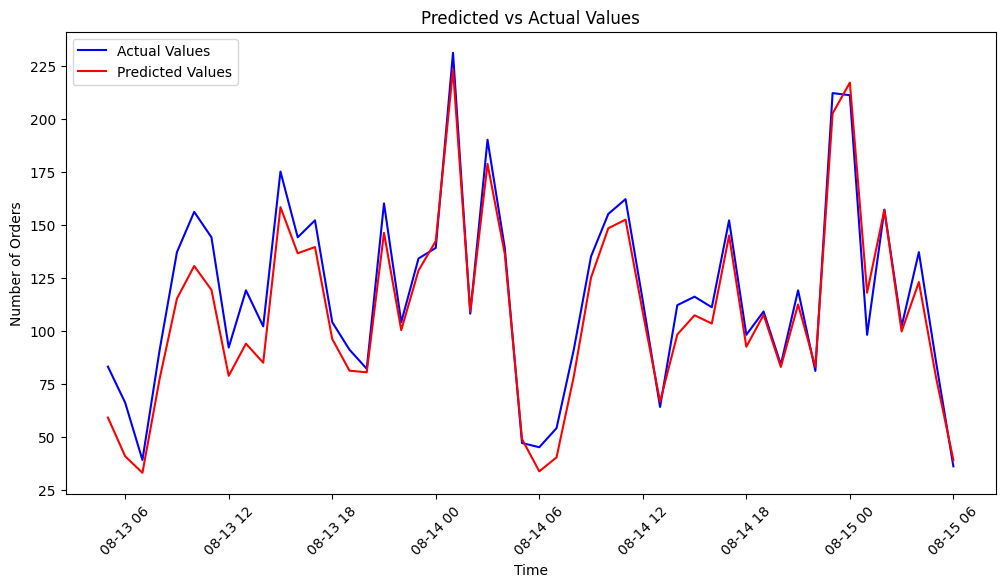

In [211]:
plt.figure(figsize=(12, 6))
plt.plot(features_test.index[:50], target_test[:50], label='Actual Values', color='blue')
plt.plot(features_test.index[:50], best_gbr_model.predict(features_test)[:50], label='Predicted Values', color='red')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.xticks(rotation=45);

# Conclusion:

<b>The objective of this project was to develop a predictive model for the Sweet Lift Taxi company to forecast the number of taxi orders in the next hour, particularly to enhance driver availability during peak times. The target was to achieve a Root Mean Squared Error (RMSE) of 48, or lower, on the test dataset, ensuring the model is sufficiently accurate for operational use.</b>

<b>Data Preparation and Exploration:</b>

- Historical taxi order data was thoroughly analyzed to understand patterns and trends.
- Data visualization techniques, including line plots, were used to display relationships within the data.
- Data Decomposition and Transformation

<b>Seasonal decomposition of the time series data was conducted.</b> This involved separating the data into its seasonal, trend, and residual components, allowing for a clearer understanding of underlying patterns.

<b>Features were created</b>
- Rolling mean and lags were calculated using the original num_orders data.
- hour, day_of_week, month, week_number were also created, using the original num_orders data.

<b>Model Development:</b>

Several predictive models were evaluated, and all four models proved to be good models.
The original num_orders data was utilized to train the models.
    
<b>Model Evaluation:</b>

<b>Models tested and their RMSE score: </b>
- Linear Regression ... RMSE 31.56
- Decision Tree  ... RMSE 46.63
- Random Forest ...  RMSE 27.66
- Gradient Boost ... RMSE 23.82

All four of the models achieved RMSE scores below the threshold of 48. This indicates strong predictive performance and model robustness in anticipating taxi demand.

<span style="color: green; font-size: 16px;"><strong>Project Goal Achieved</strong></span>

The achievement of RMSE scores lower than the target demonstrates the success of this modeling approach. The models are now capable of providing reliable forecasts for the Sweet Lift Taxi company, aiding in the optimization of driver availability and resource allocation during high-demand periods.
With these results, the Sweet Lift Taxi company is now able to make informed decisions that enhance operational efficiency and customer service by accurately predicting short-term taxi order demand.